Assuming the following structure:

$A \leftarrow X \rightarrow Y$

$A \rightarrow Y$

And the joint probability is as follows:

$P(Y,A,X)=P(Y|X,A)P(A|X)P(X)$

where:

$ X\sim U[-2, 2]$

$P(A|X) = Ber(p)$, with $p=logit(\beta_0 + \beta_1 X)$

$P(Y|X,A) \sim N(\mu =-2X+0.8A,\ \sigma^2 = 1)$

Thus, the marginal distribution of $P(Y|X)$ is:

$P(Y|X)=P(Y|X,A=0)+P(Y|X,A=1)\sim N(-4X + 0.8, \sigma^2 = 2)$


In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hBeta import PThBeta
import seaborn as sns
import pathlib
import collections
from utils.utils_func import load_database, _inv_transform, sample_pca_residuals_distribution, save_xls
from preprocessing import epi_year_cases_matrix
import matplotlib.lines as mlines
from collections import defaultdict
from utils.utils_func import _sim_square_pos
from lalonde import _load_lalonde
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from causallib.estimation import StratifiedStandardization, Standardization
from sklearn.ensemble import RandomForestRegressor
from utils.utils_summary import _load_pickle, _dyadic_cube_to_samples, _dyadic_prediction, _dyadic_cube_to_samples222


from scipy.special import expit

In [2]:
def _logit(X, beta_0=0.1, beta_1=1):
    eq = beta_0 + beta_1 * X #**2
    p = np.exp(eq) / (np.exp(eq) + 1)
    return p

def _logit_2d(X_1, X_2, beta_0=0.1, beta_1=1):
    eq = beta_0 + beta_1 * X_1 * X_2
    p = np.exp(eq) / (np.exp(eq) + 1)
    return p

## Simpson paradox in 2d (X is one dimension)

Text(0.5, 1.0, 'p - probability to be treated as function of X')

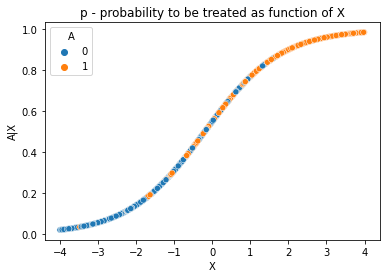

In [51]:
n_sample = 2000
X = pd.Series(np.random.uniform(-4, 4, n_sample))

p = pd.Series(_logit(X, beta_0=0.2, beta_1=1), index=X.index)
A = np.random.binomial(1, p, n_sample)
df = pd.DataFrame({'X':X, 'A|X':p, 'A':A})
# plt.plot(df.sort_values(by='X').loc[:,'X'], df.sort_values(by='X').loc[:,'A|X'])
sns.scatterplot(data=df, x="X", y="A|X", hue="A")
plt.title('p - probability to be treated as function of X')

In [12]:
np.min(p), np.max(p) 

(0.022246173598616647, 0.9849978162842441)

Text(0.5, 1.0, 'outcome Y as function of X\n(seperated by control and treatment groups)')

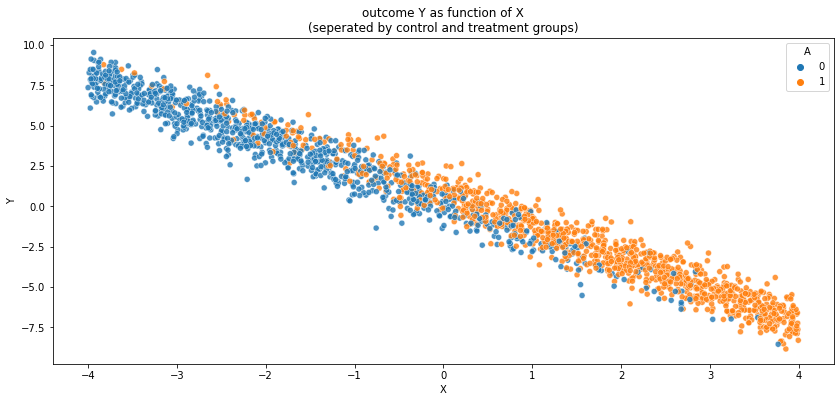

In [52]:
# Y|X,A#
fig, ax = plt.subplots(figsize=(14,6))
Y = np.random.normal(-2*X + A * 0.8, 0.8)#0.8
df['Y']= Y

sns.scatterplot(data=df, x="X", y="Y", hue="A", alpha=0.8)
plt.title('outcome Y as function of X\n(seperated by control and treatment groups)')

# x_lin = np.linspace(-2, 2, 100)
# reg_ox = LinearRegression()
# bounds = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
# for i in range(1, len(bounds)):
#     cond = (df.loc[:,'X'] < bounds[i]) & (df.loc[:,'X'] > bounds[i-1])
#     reg_ox.fit(np.array(df.loc[cond,'A']).reshape(-1, 1), df.loc[cond,'Y'])
#     y_reg_ox = x_lin* reg_ox.coef_ + reg_ox.intercept_
#     plt.plot(x_lin, y_reg_ox, c='k')

In [14]:
reg_wx, reg_ox = LinearRegression(), LinearRegression()
reg_wx.fit(df.loc[:,['X','A']], df.loc[:, 'Y'])
reg_ox.fit(np.array(df.loc[:,'A']).reshape(-1, 1), df.loc[:, 'Y'])

print('reg_wx: coef_ beta_a= {:f}, beta_x={:f}'.format(reg_wx.coef_[1], reg_wx.coef_[0]))
print('reg_ox: coef_ beta_a={:f}'.format(reg_ox.coef_[0]))

reg_wx: coef_ beta_a= 0.796251, beta_x=-1.993885
reg_ox: coef_ beta_a=-5.696138


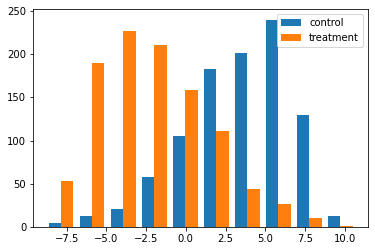

In [15]:
plt.hist([ df.loc[df.loc[:, 'A'] == 0, 'Y'], df.loc[df.loc[:, 'A'] == 1, 'Y']], label=['control', 'treatment'])
plt.legend()

In [16]:
print('Naive ATE: {:f}'.format(np.mean(df.loc[df.loc[:, 'A'] == 1, 'Y']) - np.mean(df.loc[df.loc[:, 'A'] == 0, 'Y'])))

Naive ATE: -5.696138


In [27]:


print('ATE by stratify the data\nX < -3 :{:f},\nX > 3  :{:f},\n0< X< 1  :{:f}'.format(
(np.mean(df.loc[(df.loc[:, 'A'] == 1) & (df.loc[:, 'X'] < -3.0), 'Y']) - np.mean(df.loc[(df.loc[:, 'A'] == 0) & (df.loc[:, 'X'] < -3.0), 'Y'])),
(np.mean(df.loc[(df.loc[:, 'A'] == 1) & (df.loc[:, 'X'] > 3.0), 'Y']) - np.mean(df.loc[(df.loc[:, 'A'] == 0) & (df.loc[:, 'X'] > 3.0), 'Y'])),
np.mean(df.loc[(df.loc[:, 'A'] == 1) & (df.loc[:, 'X'] > 0.0) & (df.loc[:, 'X'] < 1.0), 'Y']) 
    - np.mean(df.loc[(df.loc[:, 'A'] == 0) & (df.loc[:, 'X'] > 0.0) & (df.loc[:, 'X'] < 1.0), 'Y'])))


ATE by stratify the data
X < -3 :0.362783,
X > 3  :0.647225,
0< X< 1  :0.509964


### PThBeta

In [28]:
seg_1dim = 3
gamma = 0.2
a_0 = 1#0.1

In [29]:
df.loc[:, ['Y','X']].head()

,Y,X
0,-0.443101,0.866314
1,6.164357,-3.191700
2,-2.311107,1.199766
3,2.041389,-0.716756
4,5.466100,-3.603803


In [30]:

def _run_phbeta(df, seg_1dim, gamma, a_0):
    d_res = collections.defaultdict(dict)

    #############
    ## Treated ##
    #############
    pt = PThBeta(seg_1dim=seg_1dim)
    pt.set_int_coords(data=df.loc[:, ['Y','X']], gamma=gamma, sup_01=False)
    df_treated = df.loc[:, ['Y','X']].loc[df.loc[:, 'A'] == 1]
    pi_map_sample_treated, map_seg_pdist_treated, freq = pt.pi_hBeta_sampler(df_treated, n_pts=1000,
                                                                             gamma=gamma, a_0=a_0,
                                                                             sup_01=False, init_space=False)
    pred_sample_treated = pt.pred_map_sample(pi_map_sample_treated, map_seg_pdist_treated, n_samples=1000)
    pi_treated = pt.comp_pi_post_mean(pi_map_sample_treated, map_seg_pdist_treated)
    y_given_x = pt.conditional_expected(pi_map_sample_treated, map_seg_pdist_treated)
    p_x = pt.marginalizing_y(pi_map_sample_treated, map_seg_pdist_treated)
    d_res['treated'] = {'pi': pi_map_sample_treated, 'seg_pdist': map_seg_pdist_treated, 'y_given_x': y_given_x, 
                        'p_x_a':p_x['p_x']}

    #############
    ## Control ##
    #############

    pt = PThBeta(seg_1dim=seg_1dim)
    pt.set_int_coords(data=df.loc[:, ['Y','X']], gamma=gamma, sup_01=False)
    df_control  = df.loc[:, ['Y','X']].loc[df.loc[:, 'A'] == 0]
    pi_map_sample, map_seg_pdist, freq = pt.pi_hBeta_sampler(df_control, n_pts=1000, gamma=gamma,
                                                             a_0=a_0, sup_01=False, init_space=False)
    pred_sample = pt.pred_map_sample(pi_map_sample, map_seg_pdist, n_samples=1000)
    pi = pt.comp_pi_post_mean(pi_map_sample, map_seg_pdist)
    y_given_x = pt.conditional_expected(pi_map_sample, map_seg_pdist)
    p_x = pt.marginalizing_y(pi_map_sample, map_seg_pdist)
    d_res['control'] = {'pi': pi_map_sample, 'seg_pdist': map_seg_pdist, 'y_given_x': y_given_x, 'p_x_a':p_x['p_x']}

    p_x = (d_res['treated']['p_x_a'] + d_res['control']['p_x_a']) / 2

    d_res['treated']['p_x'] = p_x
    d_res['control']['p_x'] = p_x
    
    ATE = np.sum((d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y']) * d_res['treated']['p_x'])
    return ATE

In [40]:
print('ATE with PThbeta: {:f}'.format(
np.sum((d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y']) * d_res['treated']['p_x'])
))

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].hlines(0.8, -2, 2, linestyle='--', color='grey', label='True effect')
ax[0].scatter(x=d_res['control']['y_given_x'][0] ,y=d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y'], label='Estimated effect')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$E[Y|X,A=1] - E[Y|X,A=0]$')
ax[0].legend()

ax[1].plot(pd.unique(pd.Series(pt.arr_med[:,1])), d_res['treated']['p_x'], c='k', label='$P(X)$')
ax[1].plot(pd.unique(pd.Series(pt.arr_med[:,1])), d_res['control']['p_x_a'], label='$P(X|A=0)$ - control')
ax[1].plot(pd.unique(pd.Series(pt.arr_med[:,1])), d_res['treated']['p_x_a'], label='$P(X|A=1)$ - treated')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('density')
ax[1].legend()

KeyError: 'y_given_x'

Running a full experiment

In [32]:
def _run(n_sample = 1000, random_seed = 0):
    
    np.random.seed(random_seed)
    X = pd.Series(np.random.uniform(-2, 2, n_sample))
    p = pd.Series(_logit(X, beta_0=0.2, beta_1=1), index=X.index)
    np.random.seed(random_seed)
    A = np.random.binomial(1, p, n_sample)
    df = pd.DataFrame({'X':X, 'A|X':p, 'A':A})
    np.random.seed(random_seed)
    Y = np.random.normal(-2*X + A * 0.8, 0.8)#0.8
    df['Y']= Y
    return df


seg_1dim = 3
gamma = 0.2
a_0 = 1
n_samples = [20, 55, 149, 404, 1097]

d_res = collections.defaultdict(dict)
for n_sample in n_samples:
    for random_seed in range(6):
        data = _run(n_sample, random_seed)
        ATE  = _run_phbeta(data, seg_1dim, gamma, a_0)
        d_res[n_sample][random_seed] = ATE
        
list_of_dfs = []
for n_sample in n_samples:
    list_of_dfs.append(pd.DataFrame({'ATE': d_res[n_sample].values(), 'log(n)': np.int(np.round(np.log(n_sample),1)),
                                     'a0':a_0, 'Level':2*seg_1dim, 'seed': d_res[n_sample].keys()}))

********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0611 seconds
Elapsed time for- sampling loop: 0.7185 seconds
Elapsed time for- pi_map_sample: 0.2998 seconds
********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0570 seconds
Elapsed time for- sampling loop: 0.7840 seconds
Elapsed time for- pi_map_sample: 0.2590 seconds
********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0635 seconds
Elapsed time for- sampling loop: 0.8001 seconds
Elapsed time for- pi_map_sample: 0.3181 seconds
********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0632 seconds
Elapsed time for- sampling loop: 0.8610 seconds
Elapsed time for- pi_map_sample: 0.2813 seconds
********************
p=2, Level=6, inter

Elapsed time for- sampling loop: 0.7005 seconds
Elapsed time for- pi_map_sample: 0.2663 seconds
********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0676 seconds
Elapsed time for- sampling loop: 0.9104 seconds
Elapsed time for- pi_map_sample: 0.3232 seconds
********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0705 seconds
Elapsed time for- sampling loop: 0.7873 seconds
Elapsed time for- pi_map_sample: 0.3205 seconds
********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0691 seconds
Elapsed time for- sampling loop: 0.7165 seconds
Elapsed time for- pi_map_sample: 0.2601 seconds
********************
p=2, Level=6, intervals at level-L=64
number of differet segmentations=20
Elapsed time for- set_int_coords: 0.0795 seconds
Elapsed time for- sampling loop: 0.7130 

In [39]:
list_of_dfs

[        ATE  log(n)  a0  Level  seed
 0  0.605384       3   1      6     0
 1 -1.568387       3   1      6     1
 2 -0.325038       3   1      6     2
 3 -0.374185       3   1      6     3
 4  0.281767       3   1      6     4
 5 -0.122329       3   1      6     5,
         ATE  log(n)  a0  Level  seed
 0  0.516110       4   1      6     0
 1 -0.445070       4   1      6     1
 2  0.274678       4   1      6     2
 3  0.285526       4   1      6     3
 4  0.640875       4   1      6     4
 5  0.172041       4   1      6     5,
         ATE  log(n)  a0  Level  seed
 0  0.921408       5   1      6     0
 1  0.458509       5   1      6     1
 2  0.591167       5   1      6     2
 3  0.309486       5   1      6     3
 4  0.975741       5   1      6     4
 5  0.661285       5   1      6     5,
         ATE  log(n)  a0  Level  seed
 0  0.698316       6   1      6     0
 1  0.807516       6   1      6     1
 2  0.613292       6   1      6     2
 3  0.401952       6   1      6     3
 4  0.955

In [34]:
full_res['L6_a01'] = pd.DataFrame(d_res)

NameError: name 'full_res' is not defined

In [46]:
dff

,ATE,log(n),a0,Level,seed
0,0.605384,3,1,6,0
1,-1.568387,3,1,6,1
2,-0.325038,3,1,6,2
3,-0.374185,3,1,6,3
4,0.281767,3,1,6,4
5,-0.122329,3,1,6,5
0,0.516110,4,1,6,0
1,-0.445070,4,1,6,1
2,0.274678,4,1,6,2
3,0.285526,4,1,6,3


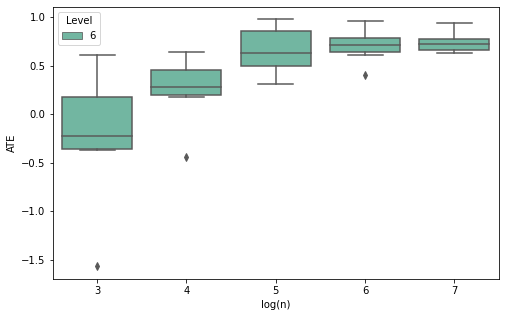

In [47]:
dff = pd.concat(list_of_dfs)

plt.subplots(figsize=(8,5))
ax = sns.boxplot(x="log(n)", y="ATE", hue="Level", showfliers=True,palette="Set2",
                 data=dff)

In [36]:
df2 = pd.concat([df2, pd.concat(list_of_dfs)], axis=0)

NameError: name 'df2' is not defined

In [37]:
df2['abs_err'] = np.abs(df2['ATE']- 0.8) 

NameError: name 'df2' is not defined

ValueError: Could not interpret input 'abs_err'

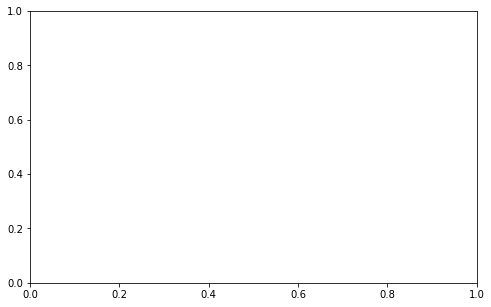

In [43]:
dff = pd.concat(list_of_dfs)

plt.subplots(figsize=(8,5))
ax = sns.boxplot(x="log(n)", y="abs_err", hue="Level", showfliers=True,palette="Set2",
                 data=df2)
ax.set_ylabel(r'$|\tau - \hat{\tau}|$')
ax.set_title('Absolute error of ATE vs. $log(n)$')

In [313]:
import causallib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = { 
        "n_estimators"      : [10,20,50],
        "max_depth" : [2,4,8]
        }


In [241]:
def _plot_boxplots(list_of_data, err='abs'):
    fig, ax = plt.subplots(nrows=1, ncols=np.int(np.ceil((len(list_of_data))/2)), figsize=(14, 4), sharey=True)
    for i, data_res in enumerate(list_of_data):
        if err == 'abs':
            _err = np.abs(data_res - 0.8 * np.ones(data_res.shape)) 
        elif err == 'se':
            _err = (data_res - 0.8 * np.ones(data_res.shape)) ** 2
        else:
            _err = data_res
        if i < 2:
            ax[0].boxplot([_err.iloc[:, col] for col in range(data_res.shape[1])], 
                          positions=np.rint(np.log(n_samples)) - 0.25 + 0.25* (i%2),
                          showfliers=False, widths=0.15, labels=np.arange(3, 8))
#             ax[0].set_xticks(np.rint(np.log(n_samples)), np.rint(np.log(n_samples)))
            locs, labels = ax[0].get_xticks()
            print(locs, labels)
            lab = ax[0].get_xticklabels()
            print(lab)
            #             ax[0].set_xticks(np.arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))
        else:
            ax[1].boxplot([_err.iloc[:, 0], _err.iloc[:, 1], _err.iloc[:, 2],
            _err.iloc[:, 3], _err.iloc[:, 4]], positions=np.rint(np.log(n_samples)) - 0.25 + 0.25* (i%2),
             showfliers=False, widths=0.15, labels=np.arange(3, 8))
plt.show()

In [157]:
list_of_data

[       20        55        149       404       1097
 0  0.015967  0.647556  0.065605  0.107855  0.060546
 1  2.417516  1.226169  0.484703  0.000039  0.009907
 2  1.114573  0.546104  0.056988  0.225843  0.104627
 3  1.360184  0.545074  0.589101  0.434178  0.127219
 4  0.472622  0.053645  0.367404  0.094088  0.067117
 5  0.744419  0.497977  0.001616  0.080021  0.037827]

ValueError: too many values to unpack (expected 2)

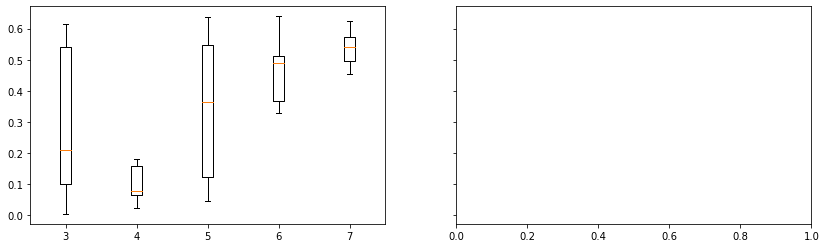

In [242]:
_plot_boxplots(list_of_data, err='se')

In [180]:
list_of_data = [ss_err, pd.DataFrame(d_res), pd.DataFrame(d_res)]



{'whiskers': [<matplotlib.lines.Line2D at 0x17ad8c77988>,
 'caps': [<matplotlib.lines.Line2D at 0x17ad8c8a5c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x17ad8a98388>,
 'medians': [<matplotlib.lines.Line2D at 0x17ad8c8ae88>,
 'fliers': [<matplotlib.lines.Line2D at 0x17ad8c92b88>,
 'means': []}

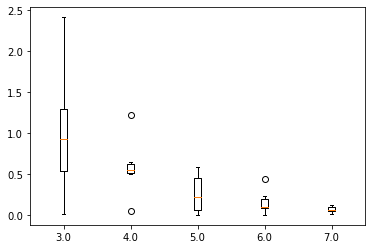

In [115]:
plt.boxplot([ss_err.iloc[:, 0], ss_err.iloc[:, 1], ss_err.iloc[:, 2],
             ss_err.iloc[:, 3], ss_err.iloc[:, 4]], positions=np.rint(np.log(n_samples)),
             widths= (0.1))

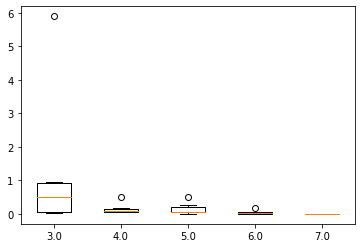

In [97]:
ss_err = (pd.DataFrame(d_res) - 0.8 * np.ones((6, 5))) ** 2

plt.boxplot([ss_err.iloc[:, 0], ss_err.iloc[:, 1], ss_err.iloc[:, 2],
             ss_err.iloc[:, 3], ss_err.iloc[:, 4]], positions=np.round(np.log(n_samples),1))
plt.show()

In [95]:
pd.DataFrame(d_res).shape

(6, 5)

In [19]:
df2 = df.copy()
sorted_index = df2['X'].sort_values().index

In [54]:
df

,X,A|X,A,Y
0,1.955473,0.896179,1,1.934060
1,-3.811797,0.026293,0,15.042654
2,2.347481,0.927404,1,1.493310
3,0.824768,0.735900,1,2.630099
4,0.788642,0.728820,0,2.739460
...,...,...,...,...
1995,-0.380097,0.455097,1,2.834520
1996,-0.156968,0.510756,0,1.113005
1997,3.709092,0.980336,1,-1.171030
1998,2.557171,0.940317,1,0.795614


## Same problem, but with more complex response surface

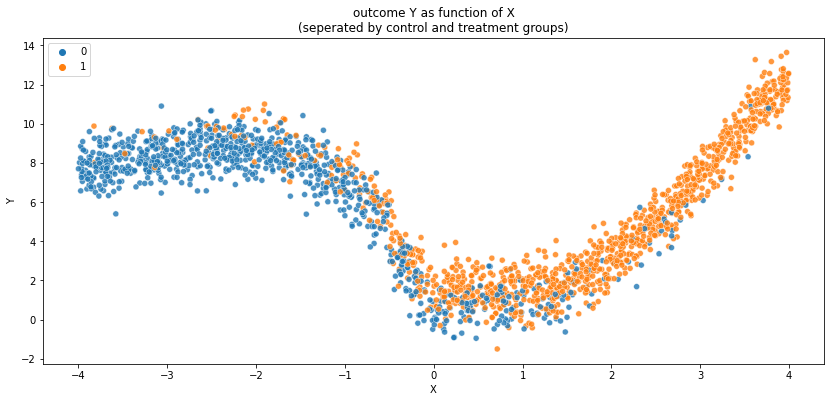

In [112]:
# Y|X,A#
fig, ax = plt.subplots(figsize=(14,6))
Y = np.random.normal(3*np.abs(X) **0.5 +0.2*X**2 -3*np.sin(X) +1*(X < -.5) + A * 0.8, 0.8)#0.8
po = 3*np.abs(X) **0.5 -2*X + np.sin(X)
df['Y']= Y

sns.scatterplot(data=df, x="X", y="Y", hue="A", alpha=0.8)
# plt.plot(df['X'].loc[sorted_index], po[sorted_index], c='k', label='$\mu_0$ - control surface')
plt.title('outcome Y as function of X\n(seperated by control and treatment groups)')
plt.legend()

In [96]:
(X < -1) *1 + 1

0       1
1       2
2       1
3       1
4       1
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Length: 2000, dtype: int32

In [113]:
print('Naive ATE: {:f}'.format(np.mean(df.loc[df.loc[:, 'A'] == 1, 'Y']) - np.mean(df.loc[df.loc[:, 'A'] == 0, 'Y'])))

print('ATE by stratify the data\nX < -3 :{:f},\nX > 3  :{:f}'.format(
(np.mean(df.loc[(df.loc[:, 'A'] == 1) & (df.loc[:, 'X'] < -3.0), 'Y']) - np.mean(df.loc[(df.loc[:, 'A'] == 0) & (df.loc[:, 'X'] < -3.0), 'Y'])),
(np.mean(df.loc[(df.loc[:, 'A'] == 1) & (df.loc[:, 'X'] > 3.0), 'Y']) - np.mean(df.loc[(df.loc[:, 'A'] == 0) & (df.loc[:, 'X'] > 3.0), 'Y']))))


Naive ATE: -1.334138
ATE by stratify the data
X < -3 :0.911885,
X > 3  :1.322547


In [120]:
seg_1dim = 4
gamma = 0.2
a_0 = 1#0.1

d_res = collections.defaultdict(dict)

#############
## Treated ##
#############
pt = PThBeta(seg_1dim=seg_1dim)
pt.set_int_coords(data=df.loc[:, ['Y','X']], gamma=gamma, sup_01=False)
df_treated = df.loc[:, ['Y','X']].loc[df.loc[:, 'A'] == 1]
pi_map_sample_treated, map_seg_pdist_treated, freq = pt.pi_hBeta_sampler(df_treated, n_pts=1000,
                                                                         gamma=gamma, a_0=a_0,
                                                                         sup_01=False, init_space=False)
pred_sample_treated = pt.pred_map_sample(pi_map_sample_treated, map_seg_pdist_treated, n_samples=1000)
pi_treated = pt.comp_pi_post_mean(pi_map_sample_treated, map_seg_pdist_treated)
y_given_x = pt.conditional_expected(pi_map_sample_treated, map_seg_pdist_treated)
p_x = pt.marginalizing_y(pi_map_sample_treated, map_seg_pdist_treated)
d_res['treated'] = {'pi': pi_map_sample_treated, 'seg_pdist': map_seg_pdist_treated, 'y_given_x': y_given_x, 
                    'p_x_a':p_x['p_x']}

#############
## Control ##
#############

pt = PThBeta(seg_1dim=seg_1dim)
pt.set_int_coords(data=df.loc[:, ['Y','X']], gamma=gamma, sup_01=False)
df_control  = df.loc[:, ['Y','X']].loc[df.loc[:, 'A'] == 0]
pi_map_sample, map_seg_pdist, freq = pt.pi_hBeta_sampler(df_control, n_pts=1000, gamma=gamma,
                                                         a_0=a_0, sup_01=False, init_space=False)
pred_sample = pt.pred_map_sample(pi_map_sample, map_seg_pdist, n_samples=1000)
pi = pt.comp_pi_post_mean(pi_map_sample, map_seg_pdist)
y_given_x = pt.conditional_expected(pi_map_sample, map_seg_pdist)
p_x = pt.marginalizing_y(pi_map_sample, map_seg_pdist)
d_res['control'] = {'pi': pi_map_sample, 'seg_pdist': map_seg_pdist, 'y_given_x': y_given_x, 'p_x_a':p_x['p_x']}

p_x = (d_res['treated']['p_x_a'] + d_res['control']['p_x_a']) / 2

d_res['treated']['p_x'] = p_x
d_res['control']['p_x'] = p_x

********************
p=2, Level=8, intervals at level-L=256
number of differet segmentations=70
Elapsed time for- set_int_coords: 1.1106 seconds
Elapsed time for- sampling loop: 10.4352 seconds
Elapsed time for- pi_map_sample: 2.6263 seconds
********************
p=2, Level=8, intervals at level-L=256
number of differet segmentations=70
Elapsed time for- set_int_coords: 1.3936 seconds
Elapsed time for- sampling loop: 11.3624 seconds
Elapsed time for- pi_map_sample: 2.7178 seconds


ATE with PThbeta: 0.912788


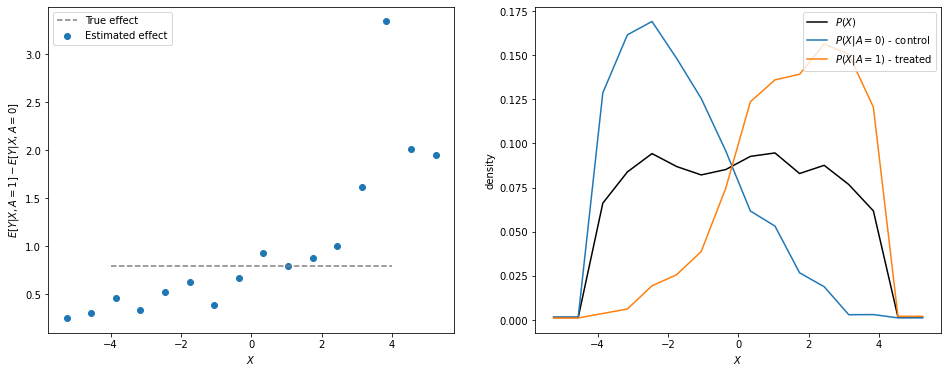

In [133]:
print('ATE with PThbeta: {:f}'.format(
np.sum((d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y']) * 
       (0.5*d_res['treated']['p_x_a'] + 0.5*d_res['control']['p_x_a'])
)))

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].hlines(0.8, -4, 4, linestyle='--', color='grey', label='True effect')
ax[0].scatter(x=d_res['control']['y_given_x'][0] ,y=d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y'], label='Estimated effect')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$E[Y|X,A=1] - E[Y|X,A=0]$')
ax[0].legend()

ax[1].plot(pd.unique(pd.Series(pt.arr_med[:,1])), d_res['treated']['p_x'], c='k', label='$P(X)$')
ax[1].plot(pd.unique(pd.Series(pt.arr_med[:,1])), d_res['control']['p_x_a'], label='$P(X|A=0)$ - control')
ax[1].plot(pd.unique(pd.Series(pt.arr_med[:,1])), d_res['treated']['p_x_a'], label='$P(X|A=1)$ - treated')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('density')
ax[1].legend()

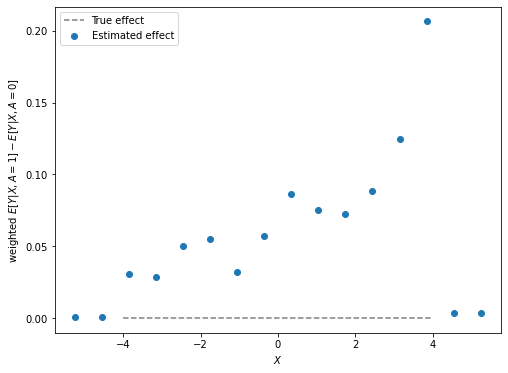

In [136]:
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.hlines(0.0, -4, 4, linestyle='--', color='grey', label='True effect')
ax.scatter(x=d_res['control']['y_given_x'][0] ,
           y=(d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y']) * (0.5*d_res['treated']['p_x_a'] + 0.5*d_res['control']['p_x_a']), 
           label='Estimated effect')
ax.set_xlabel('$X$')
ax.set_ylabel('weighted $E[Y|X,A=1] - E[Y|X,A=0]$')
ax.legend()


In [132]:
d_res['treated']['p_x']

0     0.001407
1     0.001414
2     0.066162
3     0.083862
4     0.094238
5     0.086914
6     0.082153
7     0.085205
8     0.092651
9     0.094604
10    0.082947
11    0.087585
12    0.076721
13    0.061798
14    0.001633
15    0.001633
Name: p_x, dtype: float16

In [87]:
reg_c, reg_t = LinearRegression(), LinearRegression()
reg_c.fit(X=df.loc[df.loc[:, 'A'] == 0, 'X'].values.reshape(-1, 1), y=df.loc[df.loc[:, 'A'] == 0, 'Y'])
reg_t.fit(X=df.loc[df.loc[:, 'A'] == 1, 'X'].values.reshape(-1, 1), y=df.loc[df.loc[:, 'A'] == 1, 'Y'])
# reg_c.fit(X= df.loc[df.loc[:, 'A'] == 0, 'X'], y = df.loc[df.loc[:, 'A'] == 0, 'Y'])
# reg_t.fit(df.loc[df.loc[:, 'A'] == 1, 'X'], df.loc[df.loc[:, 'A'] == 1, 'Y'])

LinearRegression()

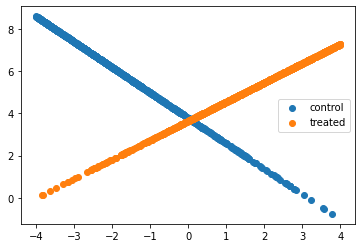

In [88]:
plt.scatter(x=df.loc[df.loc[:, 'A'] == 0, 'X'].values.reshape(-1, 1),y=reg_c.predict(df.loc[df.loc[:, 'A'] == 0, 'X'].values.reshape(-1, 1)),
           label='control')

plt.scatter(x=df.loc[df.loc[:, 'A'] == 1, 'X'].values.reshape(-1, 1),y=reg_t.predict(df.loc[df.loc[:, 'A'] == 1, 'X'].values.reshape(-1, 1)),
           label='treated')

plt.legend()

In [92]:
np.mean(reg_t.predict(df.loc[df.loc[:, 'A'] == 1, 'X'].values.reshape(-1, 1))) - np.mean(reg_c.predict(df.loc[df.loc[:, 'A'] == 0, 'X'].values.reshape(-1, 1)))

-0.7048261287142941

## Same problem, with a bit different diagram

Assuming, X - age, Z (unseen) - has gave birth, A - treatment, Y - Outcome

noncausal: $X \leftarrow Z \rightarrow A \rightarrow Y$

causal: $A \rightarrow Y$

$P(X)\sim N(55, 12)$

$P(Z|X)\sim $

(array([  7.,  14.,  45.,  80., 108.,  99.,  80.,  36.,  22.,   9.]),
 array([16.72888692, 23.29146709, 29.85404726, 36.41662744, 42.97920761,
        49.54178778, 56.10436795, 62.66694812, 69.22952829, 75.79210846,
        82.35468863]),
 <BarContainer object of 10 artists>)

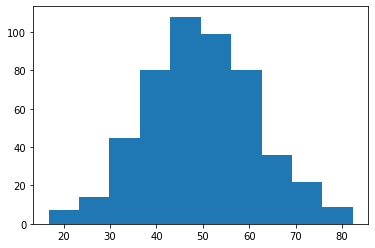

In [424]:
def _logit2(X, beta_0=0.1, beta_1=1, beta_2 = -1):
    eq = beta_0 + beta_1 * X + beta_2 * X**2
    p = np.exp(eq) / (np.exp(eq) + 1)
    return p
np.random.seed(0)
X = np.random.normal(50, 12, 500)
np.random.seed(0)
Z_X = _logit2(X, beta_0=1, beta_1=0.005, beta_2=-0.0005)#_logit2(X, beta_0=1, beta_1=0.005, beta_2=-0.0005)
Z = np.random.binomial(1, Z_X, 500)

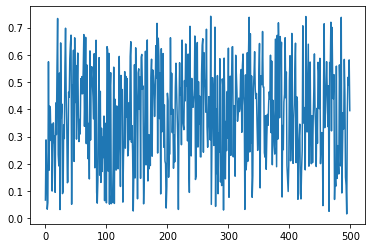

In [423]:
plt.plot(_logit2(X, beta_0=1, beta_1=0.02, beta_2=-0.001))

In [425]:
p = 0.8 * np.ones(500)
p[Z == 0] = 0.2
np.random.seed(0)
A = np.random.binomial(1, p, 500)
df = pd.DataFrame({'X':X, 'Z|X':Z_X, 'Z':Z, 'A|Z':p, 'A':A})
df

,X,Z|X,Z,A|Z,A
0,71.168628,0.235656,0,0.2,0
1,54.801887,0.443341,1,0.8,1
2,61.744856,0.354918,0,0.2,0
3,76.890718,0.171983,0,0.2,0
4,72.410696,0.221043,0,0.2,0
...,...,...,...,...,...
495,49.112904,0.509880,1,0.8,1
496,42.097364,0.580394,1,0.8,1
497,43.829192,0.564304,1,0.8,1
498,37.783497,0.616595,1,0.8,1


<AxesSubplot:xlabel='X', ylabel='Z|X'>

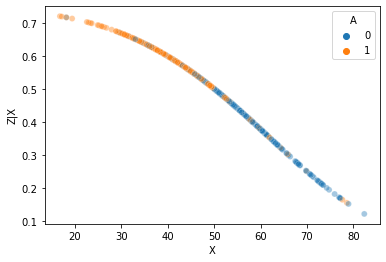

In [434]:
sns.scatterplot(data=df, x="X", y="Z|X", hue="A", alpha=0.4)

<AxesSubplot:xlabel='X', ylabel='Y'>

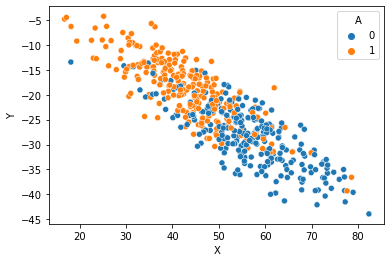

In [431]:
Y = np.random.normal(-0.5*X + A * 3, 4)#0.8
df['Y'] = Y
sns.scatterplot(data=df, x="X", y="Y", hue="A")

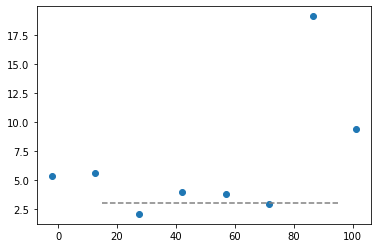

In [445]:
plt.scatter(x=d_res['control']['y_given_x'][0] ,y=d_res['treated']['y_given_x']['y'] - d_res['control']['y_given_x']['y'])
plt.hlines(3, 15, 95, linestyle='--', color='grey')

# just to make everything a bit harder

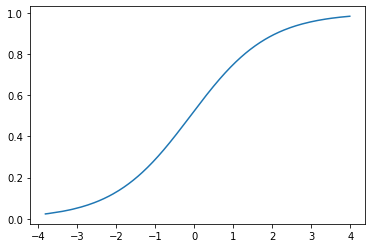

In [95]:
X_1 = pd.Series(np.random.uniform(-2, 2, 1000))
X_2 = pd.Series(np.random.uniform(-2, 2, 1000))
              
              
p = _logit_2d(X_1, X_2)
df = pd.DataFrame({'X_1X_2':X_1*X_2, 'A|X':p})
plt.plot(df.sort_values(by='X_1X_2').loc[:,'X_1X_2'], df.sort_values(by='X_1X_2').loc[:,'A|X'])

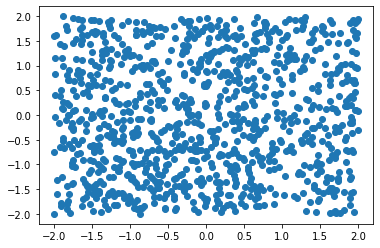

In [96]:
plt.scatter(x=X_1, y=X_2)